## Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

c:\Users\nerea\anaconda3\envs\sinthlab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Add PyalData folder to the path to import all modules

In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

## Load the data

In [5]:
data_dir = "./Data"
#fname = os.path.join(data_dir, "Sansa_20180507.mat") --> only 7 baseline reaches
fname = os.path.join(data_dir, "Sansa_20180411.mat")

In [6]:
# load TrialData .mat file into a DataFrame
group_df = mat2dataframe(fname, shift_idx_fields=True, td_name='grp')

array field StimParamNames could not be converted to int.


In [7]:
# trial_df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data') --> works with data from 07/05
trial_df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data') 

array field kin_names could not be converted to int.
array field joint_names could not be converted to int.
array field stim_param_names could not be converted to int.
field idx_end could not be converted to int.


c:\Users\nerea\OneDrive\Documentos\EPFL_MASTER\PDM\Project\PyalData\pyaldata\data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


The main dataframe here is trial_df, the group one will be used if needed to add some variables to the other one.

In [8]:
df = trial_df

`Note` Here not sure if there should be a combination of bins to make it longer and incude more spikes, but I will keep if as the demo, with now 20ms bins. 

#### **Combine time-bins into longer ones**

In [9]:
td = combine_time_bins(df, 2)
# now each bin corresponds to 20ms of recording.

#### **Remove low-firing neurons**

In [10]:
td = remove_low_firing_neurons(td, "M1_spikes",  5)
td = remove_low_firing_neurons(td, "PMd_spikes", 5)

print("original: ", df.M1_spikes[0].shape)
print("removed:  ", td.M1_spikes[0].shape)

original:  (4006, 64)
removed:   (2003, 64)


c:\Users\nerea\OneDrive\Documentos\EPFL_MASTER\PDM\Project\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
c:\Users\nerea\OneDrive\Documentos\EPFL_MASTER\PDM\Project\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


#### **Transform signals**

In [11]:
td = transform_signal(td, "M1_spikes",  'sqrt')
td = transform_signal(td, "PMd_spikes", 'sqrt')
#here we change the motor and premotor cortex spikes by their square root

#### **Merge signals from multiple areas**

Signals from the pre-motor and motor cortex are now combines in one same variable, we do not consider the 2 regions as different but more as functionally working together.

In [12]:
td = merge_signals(td, ["M1_spikes", "PMd_spikes"], "both_spikes")

print(f"Merging M1 and PMd gives {td.M1_spikes[0].shape[1]} + {td.PMd_spikes[0].shape[1]} = {td.both_spikes[0].shape[1]} neurons")

Merging M1 and PMd gives 64 + 62 = 126 neurons


#### **Calculate firing rates from spikes**

In [13]:
# works on "_spikes" fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth')

#### **Keep only the successful trials**

#### For this part of the project we do not need perfect reach trials, only to decode the motor intention in baseline trials.

In [14]:
# print("all trials:", td.shape[0])

# #td = select_trials(td, "result == 'R'") --> previously this, not sure if the new "results" column is actually the "file quality"

# td = select_trials(td, "file_quality == 0")

# print("successful trials:", td.shape[0])

In [15]:
td.head(3)

,kin_names,joint_names,bin_size,type,tonic_stim_params,reach_stim_params,pull_stim_params,stim_param_names,file_quality,idx_reach,...,angles,pressure,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates
0,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",0,"[355, 868, 1239]",...,"[[125.70427121348011, 87.74360773270831, 83.53...","[0.24260426226626658, 0.1949649981412115, 0.16...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[10.931265, 32.14764, 57.054085, 0.0, 23.5455...","[[6.7682605, 21.413494, 30.117538, 0.0, 1.5277...","[[10.931265, 32.14764, 57.054085, 0.0, 23.5455..."
1,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",0,"[594, 1174, 1620]",...,"[[122.00360654584668, 84.84301097880882, 145.3...","[0.18561099585237673, 0.20839038015273473, 0.1...","[[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.41...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.4142135623730951,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.41...","[[10.841388, 71.55765, 21.447987, 17.526516, 4...","[[12.991606, 46.758377, 10.784643, 30.46665, 3...","[[10.841388, 71.55765, 21.447987, 17.526516, 4..."
2,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",1,"[452, 878, 1302, 1703, 2115]",...,"[[129.17933050396294, 93.91122628125052, 102.8...","[0.214382344569774, 0.1942806410151383, 0.1795...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 1.7320508075688772, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[3.2982376, 22.466301, 24.255087, 0.021171728...","[[0.6211146, 77.667534, 29.745773, 0.0, 2.3554...","[[3.2982376, 22.466301, 24.255087, 0.021171728..."


FROM HERE WORK ON DIVIDING TRIALS BY THE DIFFERENT REACHES AND COMBINING ALL TO FEED DECODERS


In [16]:
td['idx_bad']

0     [506, 1536]
1             781
2            2208
3     [746, 1573]
4             551
5             371
6              -1
7            1170
8             883
9              -1
10           1580
11            828
12            933
Name: idx_bad, dtype: object

In [17]:
td['idx_end']

0                               935
1                      [1236, 1697]
2            [528, 952, 1375, 1773]
3           [348, 1176, 1995, 2448]
4     [943, 1362, 1779, 2371, 2768]
5           [780, 1213, 1619, 2155]
6                  [454, 855, 1381]
7          [1517, 1959, 2563, 2979]
8                 [454, 1359, 1781]
9      [421, 887, 1273, 1858, 2244]
10          [870, 2077, 2423, 2787]
11          [437, 1402, 1779, 2264]
12                              530
Name: idx_end, dtype: object

In [18]:
td['idx_end_complete'] = td.apply(lambda x: add_bad_idx(x['idx_end'], x['idx_bad']), axis=1)
# Apply the function to each row
td['bad_indices'] = td.apply(find_bad_indices, axis=1)

In [19]:
td['idx_start_test'] = td.idx_reach.apply(lambda x: x[0]).astype('int64')

In [20]:
td['idx_end_test'] = td.idx_end_complete.apply(lambda x: x[0]).astype('int64')

### From here testing to create tydy data and only extract windows for the reaches in each trial

In [21]:
#group_filt = group_df.loc[group_df.Quality == 0].reset_index() --> For now keeping all trials

In [22]:
#td_all = pd.concat([td,group_filt.drop(columns = 'type')], axis = 1)

td_all = pd.concat([td,group_df.drop(columns = 'type')], axis = 1)

In [23]:
group_df.head()

,num,Quality,type,Tonic,Baseline,BCReach,BCPull,BCReachPull,TonicStimParams,ReachStimParams,PullStimParams,ViconFileName,BlackrockFileName,TDTFileName,StimParamNames
0,2,0,BASELINE,0,1,0,0,0,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",20180411_KRG_TonicStim-02.mat,20180411_KRG_TonicStim002.nev,Sansa_20180411_BASELINE_1,"[PIN, AMP, PW, FREQ, Length]"
1,3,0,BASELINE,0,1,0,0,0,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",20180411_KRG_TonicStim-03.mat,20180411_KRG_TonicStim003.nev,Sansa_20180411_BASELINE_1-1,"[PIN, AMP, PW, FREQ, Length]"
2,4,1,BASELINE,0,1,0,0,0,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",20180411_KRG_TonicStim-04.mat,20180411_KRG_TonicStim004.nev,Sansa_20180411_BASELINE_1-2,"[PIN, AMP, PW, FREQ, Length]"
3,6,1,BASELINE,0,1,0,0,0,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",20180411_KRG_TonicStim-06.mat,20180411_KRG_TonicStim006.nev,Sansa_20180411_BASELINE_2,"[PIN, AMP, PW, FREQ, Length]"
4,7,1,BASELINE,0,1,0,0,0,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",20180411_KRG_TonicStim-07.mat,20180411_KRG_TonicStim007.nev,Sansa_20180411_BASELINE_3,"[PIN, AMP, PW, FREQ, Length]"


In [24]:
td.head()

,kin_names,joint_names,bin_size,type,tonic_stim_params,reach_stim_params,pull_stim_params,stim_param_names,file_quality,idx_reach,...,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates,idx_end_complete,bad_indices,idx_start_test,idx_end_test
0,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",0,"[355, 868, 1239]",...,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[10.931265, 32.14764, 57.054085, 0.0, 23.5455...","[[6.7682605, 21.413494, 30.117538, 0.0, 1.5277...","[[10.931265, 32.14764, 57.054085, 0.0, 23.5455...","[506, 935, 1536]","[1, 0, 1]",355,506
1,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",0,"[594, 1174, 1620]",...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.4142135623730951,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.41...","[[10.841388, 71.55765, 21.447987, 17.526516, 4...","[[12.991606, 46.758377, 10.784643, 30.46665, 3...","[[10.841388, 71.55765, 21.447987, 17.526516, 4...","[781, 1236, 1697]","[0, 0, 0]",594,781
2,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",1,"[452, 878, 1302, 1703, 2115]",...,"[[0.0, 1.7320508075688772, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[3.2982376, 22.466301, 24.255087, 0.021171728...","[[0.6211146, 77.667534, 29.745773, 0.0, 2.3554...","[[3.2982376, 22.466301, 24.255087, 0.021171728...","[528, 952, 1375, 1773, 2208]","[0, 0, 0, 0, 0]",452,528
3,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",1,"[277, 649, 1088, 1457, 1910, 2362]",...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 13.468173, 51.28231, 0.66611975, 17.609...","[[0.0031754556, 28.713373, 20.707687, 0.0, 9.8...","[[0.0, 13.468173, 51.28231, 0.66611975, 17.609...","[348, 746, 1176, 1573, 1995, 2448]","[0, 1, 0, 1, 0, 0]",277,348
4,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",1,"[391, 872, 1291, 1698, 2294, 2694]",...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 5.0475116, 0.0, 7.9226025e-05, 46.28899...","[[10.928668, 33.205875, 3.5228968, 0.23258345,...","[[0.0, 5.0475116, 0.0, 7.9226025e-05, 46.28899...","[551, 943, 1362, 1779, 2371, 2768]","[0, 0, 0, 0, 0, 0]",391,551


In [25]:

cols_to_search = ['index', 'num', 'type', 'KUKAPos',
               'idx_kuka_go', 'idx_reach', 'idx_end_complete',
               'bad_indices', 'x', 'y', 'z', 'angles', 'both_spikes', 'both_rates']
cols_to_keep = [c for c in cols_to_search if c in td_all.columns]
td_filt = td_all[cols_to_keep]


In [26]:
td_filt = td_filt.loc[td_filt.type == 'BASELINE'].reset_index()

In [27]:
td_filt['test_start'] = td_filt['idx_reach'].apply(lambda x: x[0])

In [28]:
td_filt['test_end'] = td_filt['idx_end_complete'].apply(lambda x: x[0])

In [29]:
td_filt

,index,num,type,idx_kuka_go,idx_reach,idx_end_complete,bad_indices,x,y,z,angles,both_spikes,both_rates,test_start,test_end
0,0,2,BASELINE,"[421, 840, 1439]","[355, 868, 1239]","[506, 935, 1536]","[1, 0, 1]","[[144.6287384033203, 118.29212188720703, 140.1...","[[67.35685348510742, 100.68180084228516, 115.1...","[[236.80768585205078, 200.8806381225586, 202.3...","[[125.70427121348011, 87.74360773270831, 83.53...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[10.931265, 32.14764, 57.054085, 0.0, 23.5455...",355,506
1,1,3,BASELINE,"[682, 1146, 1594, 2030]","[594, 1174, 1620]","[781, 1236, 1697]","[0, 0, 0]","[[163.23255157470703, 169.02262115478516, 194....","[[78.9446029663086, 119.7161979675293, 122.069...","[[236.52513122558594, 201.79024505615234, 203....","[[122.00360654584668, 84.84301097880882, 145.3...","[[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.41...","[[10.841388, 71.55765, 21.447987, 17.526516, 4...",594,781
2,2,4,BASELINE,"[434, 848, 1253, 1659, 2050]","[452, 878, 1302, 1703, 2115]","[528, 952, 1375, 1773, 2208]","[0, 0, 0, 0, 0]","[[143.2322769165039, 118.94128036499023, 139.2...","[[69.30123901367188, 99.99187850952148, 113.80...","[[238.27680206298828, 199.70963287353516, 201....","[[129.17933050396294, 93.91122628125052, 102.8...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[3.2982376, 22.466301, 24.255087, 0.021171728...",452,528
3,3,6,BASELINE,"[278, 667, 1059, 1476, 1879, 2336]","[277, 649, 1088, 1457, 1910, 2362]","[348, 746, 1176, 1573, 1995, 2448]","[0, 1, 0, 1, 0, 0]","[[143.8459930419922, 120.85192489624023, 141.4...","[[70.73051452636719, 104.8153305053711, 117.68...","[[236.01577758789062, 199.5228271484375, 202.5...","[[125.41785074499553, 79.87206402786927, 113.2...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 13.468173, 51.28231, 0.66611975, 17.609...",277,348
4,4,7,BASELINE,"[370, 855, 1270, 1682, 2089, 2669]","[391, 872, 1291, 1698, 2294, 2694]","[551, 943, 1362, 1779, 2371, 2768]","[0, 0, 0, 0, 0, 0]","[[145.0169219970703, 115.50852966308594, 136.7...","[[77.22670364379883, 113.44452285766602, 128.2...","[[231.3188018798828, 199.53001403808594, 202.4...","[[119.128187240726, 75.762578540329, 114.25240...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 5.0475116, 0.0, 7.9226025e-05, 46.28899...",391,551
5,5,8,BASELINE,"[276, 689, 1098, 1494, 1935]","[188, 704, 1118, 1539, 2092]","[371, 780, 1213, 1619, 2155]","[0, 0, 0, 0, 0]","[[139.19622802734375, 116.22307586669922, 137....","[[71.0434684753418, 102.670654296875, 114.8549...","[[237.99559020996094, 200.58351135253906, 201....","[[130.1189963096778, 99.4171346037191, 75.6002...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0031754556, 0.018747408, 0.6061999, 2...",188,371
6,6,10,BASELINE,"[360, 771, 1279]","[382, 761, 1302]","[454, 855, 1381]","[0, 0, 0]","[[139.75526428222656, 127.58711242675781, 148....","[[71.73644256591797, 121.63993072509766, 120.3...","[[233.42015075683594, 189.7831039428711, 203.5...","[[121.10879828086938, 98.76445285345997, 98.11...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.07483448, 9.803251, 8.67154, 0.20692046, 4...",382,454
7,7,11,BASELINE,"[1045, 1442, 1869, 2293, 2850]","[959, 1459, 1878, 2472, 2885]","[1170, 1517, 1959, 2563, 2979]","[0, 0, 0, 0, 0]","[[237.17654418945312, 307.5448303222656, 320.3...","[[24.153531074523926, -27.251327514648438, -37...","[[188.2254180908203, 154.70364379882812, 172.5...","[[98.60138559930012, 155.84426871383258, 79.05...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.4142135...","[[0.0, 14.567555, 16.638445, 6.10222, 20.01207...",959,1170
8,8,13,BASELINE,"[350, 783, 1268, 1694]","[386, 750, 1265, 1713]","[454, 883, 1359, 1781]","[0, 0, 0, 0]","[[227.74339294433594, 266.5364074707031, 275.3...","[[42.87641716003418, 21.32205581665039, 3.2579...","[[191.9911346435547, 155.8096923828125, 152.09...","[[122.80296054215813, 145.25826166138353, 36.7...","[[0.0, 0.0, 0.0, 1.4142135623730951, 1.0, 0.0,...","[[0.0, 16

In [30]:
win_df = split_time_fields(td_filt, start_margin = 5, end_margin = 10)

`Note`angle 3 is better to visualize X data and angle 4 for Y data.

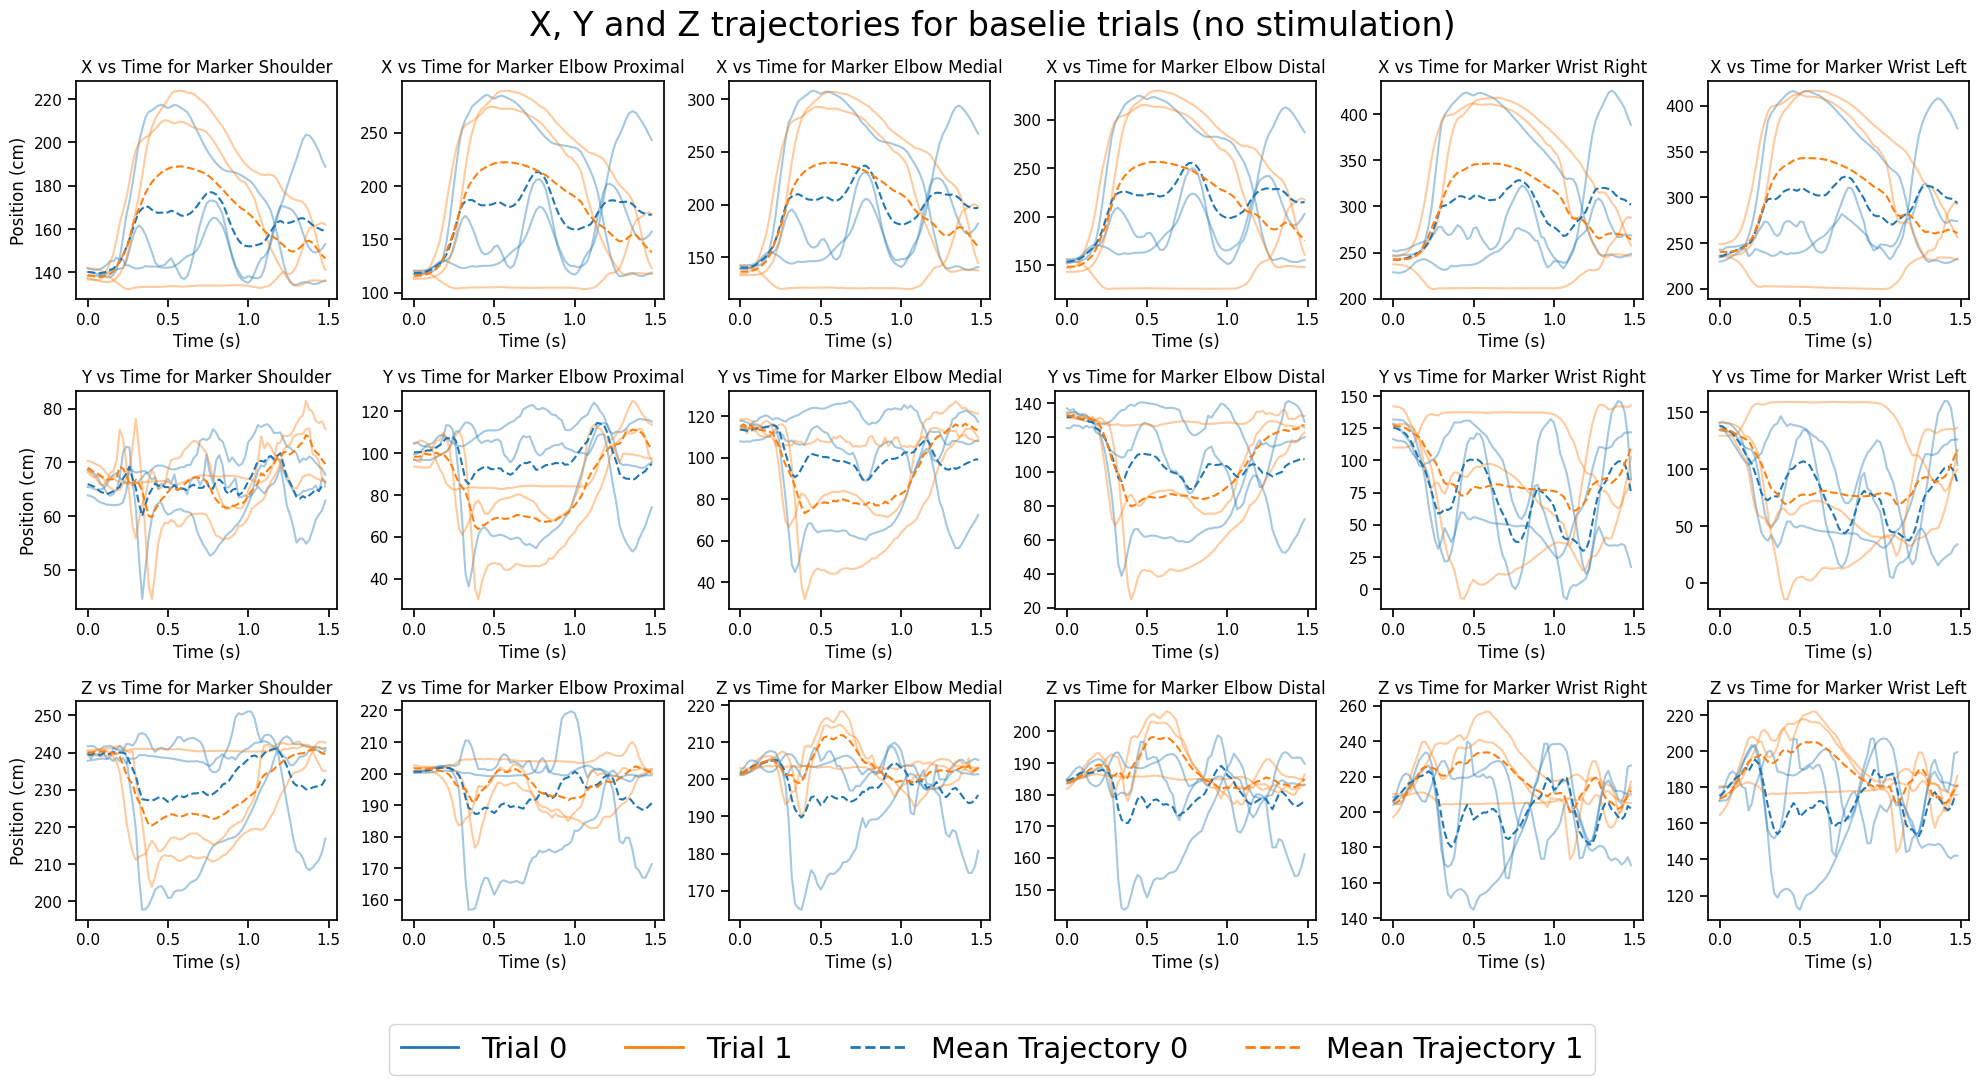

In [31]:
# Visualize the trajectories, split by reach trial
visualize_traj(win_df, ['x', 'y', 'z'], marker_names = ['Shoulder',	'Elbow Proximal',	'Elbow Medial',	'Elbow Distal',	'Wrist Right',	'Wrist Left'])  # Replace df with your actual DataFrame containing trajectory data


In [32]:
win_df['angles'] = np.nan_to_num(win_df['angles'], nan = 0)

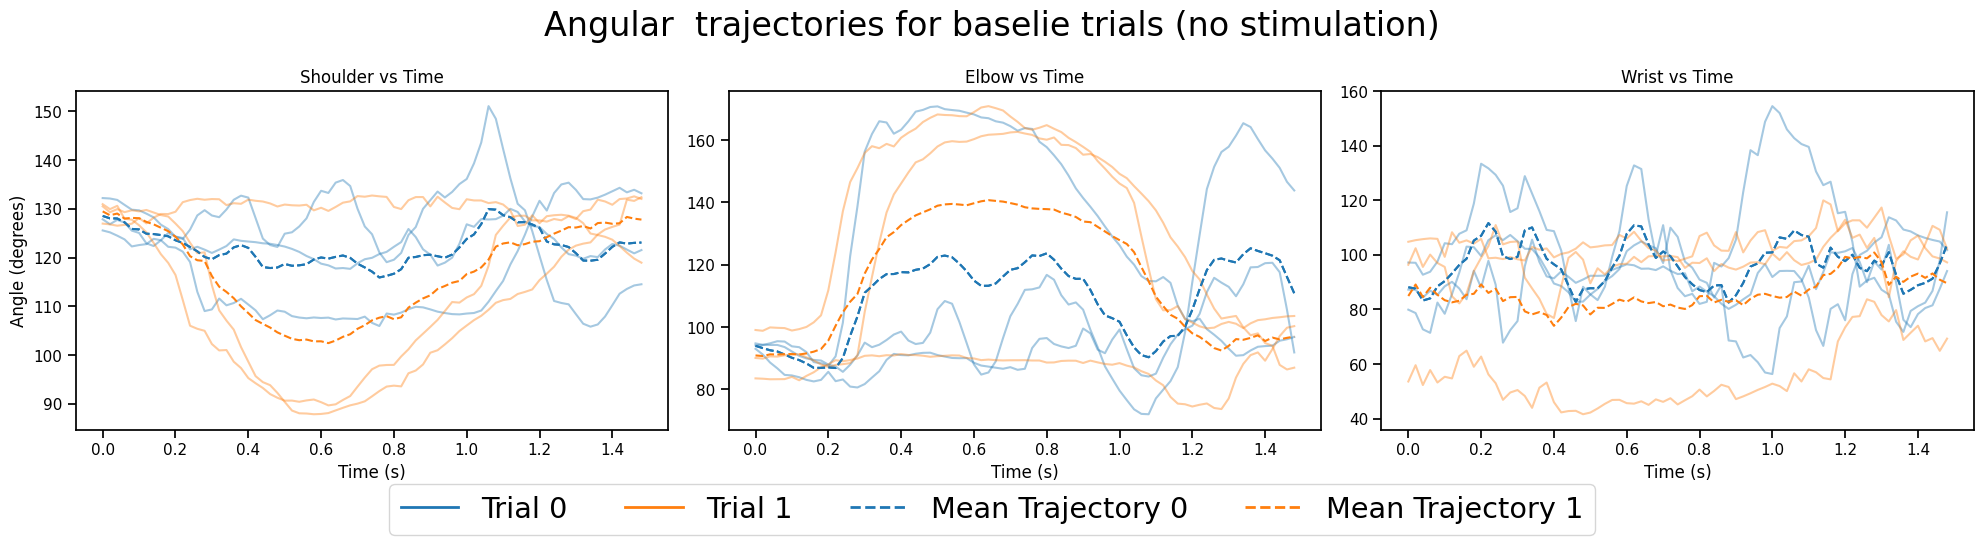

In [33]:
visualize_angles(win_df, 'angles',  angle_names = ['Shoulder', 'Elbow', 'Wrist'])

In [34]:
tidy_df = build_tidy_df(td_filt, start_margin = 5)

In [35]:
tidy_df.head()

,num,type,trial_num,reach_num,time_sample,x,y,z,angles,both_spikes,both_rates
0,2,BASELINE,0,0,0,"[141.9524688720703, 117.76282501220703, 139.16...","[65.41489028930664, 99.49823760986328, 115.036...","[237.76589965820312, 200.17157745361328, 202.2...","[125.56201945487668, 92.97474431295734, 79.900...","[0.0, 1.0, 1.7320508075688772, 0.0, 1.0, 0.0, ...","[5.9548197, 45.886963, 68.468704, 18.417976, 5..."
1,2,BASELINE,0,0,1,"[141.61994171142578, 117.60234832763672, 138.8...","[65.34469223022461, 99.77312850952148, 114.737...","[237.94485473632812, 200.23880767822266, 203.0...","[125.17232086368108, 91.1445968398082, 78.6559...","[0.0, 1.0, 1.4142135623730951, 0.0, 1.73205080...","[4.343852, 45.023403, 62.56575, 21.267706, 55...."
2,2,BASELINE,0,0,2,"[141.2461166381836, 117.7826156616211, 138.838...","[65.0521011352539, 100.54141235351562, 114.198...","[238.06502532958984, 200.2272491455078, 204.26...","[124.48984102714384, 88.5741798564234, 72.6905...","[0.0, 0.0, 0.0, 1.4142135623730951, 1.0, 0.0, ...","[3.3459194, 44.49601, 58.412594, 25.270174, 57..."
3,2,BASELINE,0,0,3,"[141.2598876953125, 118.60165786743164, 139.72...","[64.8819580078125, 102.31023406982422, 114.458...","[238.18016052246094, 200.2751922607422, 205.07...","[123.7284562916085, 86.70615728753297, 71.4142...","[0.0, 1.4142135623730951, 1.0, 0.0, 1.0, 1.0, ...","[3.4565468, 44.71479, 57.156033, 28.645653, 58..."
4,2,BASELINE,0,0,4,"[141.6452407836914, 120.00676727294922, 141.61...","[64.9525032043457, 103.99240493774414, 117.624...","[238.32097625732422, 200.2256088256836, 205.04...","[122.28155333822971, 84.60288889257947, 82.495...","[0.0, 1.0, 1.0, 1.0, 1.4142135623730951, 0.0, ...","[4.779505, 45.730453, 58.930023, 29.986374, 59..."


In [36]:
tidy_df.both_rates

0       [5.9548197, 45.886963, 68.468704, 18.417976, 5...
1       [4.343852, 45.023403, 62.56575, 21.267706, 55....
2       [3.3459194, 44.49601, 58.412594, 25.270174, 57...
3       [3.4565468, 44.71479, 57.156033, 28.645653, 58...
4       [4.779505, 45.730453, 58.930023, 29.986374, 59...
                              ...                        
4270    [15.950457, 29.534742, 24.916628, 3.7469778, 3...
4271    [16.871967, 33.64585, 29.089046, 6.103397, 41....
4272    [16.457558, 34.871864, 32.61685, 9.341395, 45....
4273    [15.780197, 33.258392, 34.641247, 12.727289, 4...
4274    [15.782374, 30.006481, 35.28018, 15.445626, 53...
Name: both_rates, Length: 4275, dtype: object

In [37]:
a = pd.concat([tidy_df.both_rates[:1], tidy_df.both_rates[:-1]]).reset_index().drop(columns = 'index')

In [38]:
b = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1],  tidy_df.both_rates[:-2]]).reset_index().drop(columns = 'index')
c = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1],tidy_df.both_rates[:1],  tidy_df.both_rates[:-3]]).reset_index().drop(columns = 'index')
d = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:-4]]).reset_index().drop(columns = 'index')
e = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1], tidy_df.both_rates[:-5]]).reset_index().drop(columns = 'index')

In [39]:
tidy_df.both_rates_augmented = pd.concat([tidy_df.both_rates, a,b,c,d,e], axis = 1)

C:\Users\nerea\AppData\Local\Temp\ipykernel_22856\3991737655.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tidy_df.both_rates_augmented = pd.concat([tidy_df.both_rates, a,b,c,d,e], axis = 1)


In [40]:
tidy_df.both_rates_augmented.head(7)

,both_rates,both_rates,both_rates,both_rates,both_rates,both_rates
0,"[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5..."
1,"[4.343852, 45.023403, 62.56575, 21.267706, 55....","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5..."
2,"[3.3459194, 44.49601, 58.412594, 25.270174, 57...","[4.343852, 45.023403, 62.56575, 21.267706, 55....","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5..."
3,"[3.4565468, 44.71479, 57.156033, 28.645653, 58...","[3.3459194, 44.49601, 58.412594, 25.270174, 57...","[4.343852, 45.023403, 62.56575, 21.267706, 55....","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5..."
4,"[4.779505, 45.730453, 58.930023, 29.986374, 59...","[3.4565468, 44.71479, 57.156033, 28.645653, 58...","[3.3459194, 44.49601, 58.412594, 25.270174, 57...","[4.343852, 45.023403, 62.56575, 21.267706, 55....","[5.9548197, 45.886963, 68.468704, 18.417976, 5...","[5.9548197, 45.886963, 68.468704, 18.417976, 5..."
5,"[7.0319633, 47.330982, 62.866917, 28.99821, 58...","[4.779505, 45.730453, 58.930023, 29.986374, 59...","[3.4565468, 44.71479, 57.156033, 28.645653, 58...","[3.3459194, 44.49601, 58.412594, 25.270174, 57...","[4.343852, 45.023403, 62.56575, 21.267706, 55....","[5.9548197, 45.886963, 68.468704, 18.417976, 5..."
6,"[9.631506, 49.152435, 67.69234, 26.797787, 57....","[7.0319633, 47.330982, 62.866917, 28.99821, 58...","[4.779505, 45.730453, 58.930023, 29.986374, 59...","[3.4565468, 44.71479, 57.156033, 28.645653, 58...","[3.3459194, 44.49601, 58.412594, 25.270174, 57...","[4.343852, 45.023403, 62.56575, 21.267706, 55...."


In [41]:
tidy_df.both_rates_augmented = tidy_df.both_rates_augmented.apply(lambda row: ', '.join(map(str, row)), axis=1)


ME HE QUEDADO AQUÍ, ASEGURARSE QUE ESTÁ BIEN HECHO!!!!!!!!!!!!!!!!!!!!!!!!

In [36]:
tidy_df['target_pos'] = tidy_df.apply(lambda x: np.concatenate([x['x'][4:5], x['y'][4:5], x['z'][4:5]]), axis = 1)

#### **Further preprocess by subtracting cross-condition mean**

In [37]:
# aka center per time point
move_td = subtract_cross_condition_mean(tidy_df) # --> maybe not needed here, I'll still standardize data later

In [38]:
tidy_df['id'] = tidy_df['trial_num'].astype(str) + '_' + tidy_df['reach_num'].astype(str)

We now want to split this data into training-validation-test by doing:

- split by reach_number 
- maximum amount of trial numbers represented in the validation/test data 
- homogeneous distribution of the KUKAPos is possible (changes the trajectory, so that the model does not learn only 1 specific trajectory) 
- Here the type is always BASELINE, as it is the first model, then we will decide if we train also using BC-PULL data or we only test on that.

Now the next question is "What do we want to predict exactly?"

Options:

- Predict only x or y vector with all markers.
- Predict a vector combining all markers for all directions.
- Create an additional variable, combining all the previous information.
- Predict the angles instead of the marker positions.


For the first model let's say we use only "both_rates" as X matrix and "x" position (including all markers) as target (or y). 

In [39]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(tidy_df, target_variable = 'target_pos', num_folds = 5)

Test trials  11
Val trials 9
fold 0  train_ids  ['5_1', '3_0', '8_3', '11_3', '1_1', '2_2', '9_0', '9_3', '4_4', '2_1', '11_1', '7_2', '4_2', '5_0', '4_1', '6_1', '10_0', '2_3', '8_0', '10_1', '4_0', '11_2', '5_3', '2_4', '5_4', '3_1', '0_0', '6_2', '3_2', '8_1', '2_0', '3_5', '7_3', '3_3', '11_4', '9_4', '4_3']
fold 0  val_ids  ['9_1', '11_0', '12_1', '1_0', '1_2', '7_4', '0_1', '10_4', '6_0']
fold 0  test_ids  ['7_0', '10_3', '9_1', '11_0', '12_1', '1_0', '1_2', '7_4', '0_1', '10_4', '6_0']
fold 1  train_ids  ['9_1', '5_1', '11_4', '3_1', '0_0', '6_1', '0_2', '11_2', '7_2', '6_2', '2_1', '11_3', '10_0', '7_3', '10_3', '10_1', '12_1', '0_1', '3_0', '3_5', '3_2', '2_0', '9_4', '4_0', '4_4', '1_0', '5_2', '10_2', '9_3', '1_2', '3_3', '8_2', '11_0', '10_4', '5_0', '5_3', '12_0']
fold 1  val_ids  ['8_3', '1_1', '4_5', '4_2', '4_3', '2_4', '7_1', '9_2', '7_4']
fold 1  test_ids  ['4_1', '3_4', '8_3', '1_1', '4_5', '4_2', '4_3', '2_4', '7_1', '9_2', '7_4']
fold 2  train_ids  ['10_0', '3_5', 

Here we want to analyse the target distribution.
We will use fold 0 as an example, as we expect the rest to be similar.

In [40]:
y_test_dist = y_test['fold0']

0  mean  0.5059451422165644  median  0.5287134174787671  mode  [0.004]  std dev  0.29367755899635256
1  mean  0.438435598684746  median  0.3754699258935343  mode  [0.813]  std dev  0.20626779595062353
2  mean  0.5693381977197233  median  0.5740002563641378  mode  [0.533]  std dev  0.17426344652298908


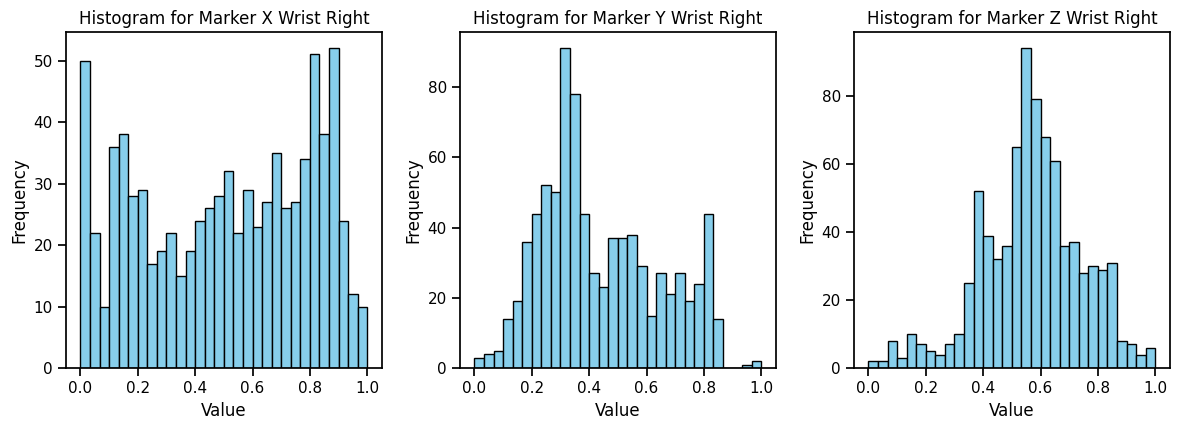

In [41]:
# Get the number of markers (features)
num_markers = y_test_dist.shape[1]

# Plot histograms for each marker
plt.figure(figsize=(12, 8))
#marker_names =  ['Shoulder',	'Elbow Proximal',	'Elbow Medial',	'Elbow Distal',	'Wrist Right',	'Wrist Left']
marker_names = ['X Wrist Right', 'Y Wrist Right', 'Z Wrist Right']
for i in range(num_markers):
    plt.subplot(2, 3, i+1)  # Adjust the subplot layout as needed
    plt.hist(y_test_dist[:, i], bins=30, color='skyblue', edgecolor='black')
    print(i, ' mean ', np.mean(y_test_dist[:,i]), ' median ', np.median(y_test_dist[:,i]), ' mode ', calculate_mode(y_test_dist[:,i]), ' std dev ', np.std(y_test_dist[:,i]))
    #skewness, and kurtosis
    plt.title(f'Histogram for Marker {marker_names[i]}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Explanation of what function to use as activation for my LSTM based on the data description and analysis:

If your output represents a 0-1 distribution that is left-skewed but gradually increases towards the right, you would typically want to use an activation function that can handle bounded outputs and is capable of capturing non-linear relationships. In this scenario, the best choice of activation function after the second linear layer could be the **sigmoid activation function**.

The sigmoid function has the following properties:

- *Bounded Output*: The output of the sigmoid function is bounded between 0 and 1, which aligns with your distribution.

- *Non-linearity*: The sigmoid function introduces non-linearity to the model, allowing it to capture complex relationships between features and outputs.

- *Smooth Gradient*: The sigmoid function has a smooth gradient, which facilitates stable training via backpropagation.

## Ridge Regression

In [42]:
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, FactorAnalysis

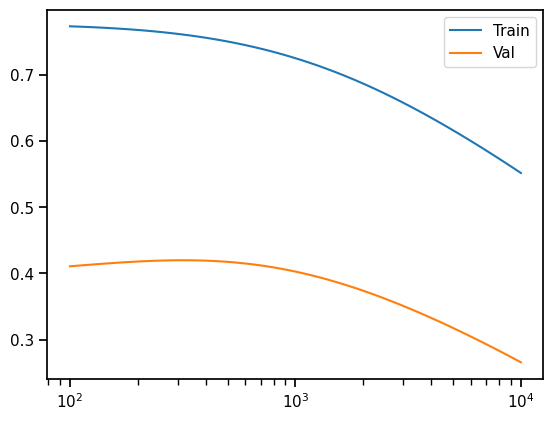

In [43]:
num_folds = 5
dim_reduce = False
num_dim = 10

alphas = np.logspace(2, 4, 50)

test_score = []
train_score = []
best_a = []

for i in range(num_folds):
    train_score_a = []
    val_score_a = []

    best_score = -np.inf  # Initialize best score to negative infinity
    best_model = None

    for a in alphas:
        if dim_reduce == True:

            PCA_model = PCA(num_dim).fit(X_train['fold'+str(i)])
            X_train_ = PCA_model.transform(X_train['fold'+str(i)])
            X_val_ = PCA_model.transform(X_val['fold'+str(i)])
            X_test_ = PCA_model.transform(X_test['fold'+str(i)])
        else:
            X_train_ = X_train['fold'+str(i)]
            X_val_ = X_val['fold'+str(i)]
            X_test_ = X_test['fold'+str(i)]

        model = Ridge(alpha = a, fit_intercept=True)
        model.fit(X_train_, y_train['fold'+str(i)])
        score = model.score(X_val_, y_val['fold'+str(i)])
        train_score_a.append(model.score(X_train_, y_train['fold'+str(i)]))
        val_score_a.append(score)

        # Check if current model has better validation score than previous best
        if score > best_score:
            best_score = score
            best_model = model
    if i == 3:
        plt.plot(alphas, train_score_a, label = 'Train')
        plt.plot(alphas, val_score_a, label = 'Val')
        plt.xscale('log')
        plt.legend()

    best_a.append(alphas[np.argmax(val_score_a)])
    test_score.append(best_model.score(X_test_, y_test['fold'+str(i)]))
    train_score.append(best_model.score(X_train_, y_train['fold'+str(i)]))


In [44]:
best_a

[542.867543932386,
 596.3623316594643,
 596.3623316594643,
 308.88435964774817,
 596.3623316594643]

In [45]:
train_score

[0.7325291630791542,
 0.741938195391993,
 0.7074772284267619,
 0.7608190224613564,
 0.7259098495519624]

In [46]:
test_score

[0.4581907405511168,
 0.5081638977800474,
 0.5709101588271471,
 0.4600311833382295,
 0.5427360288589743]

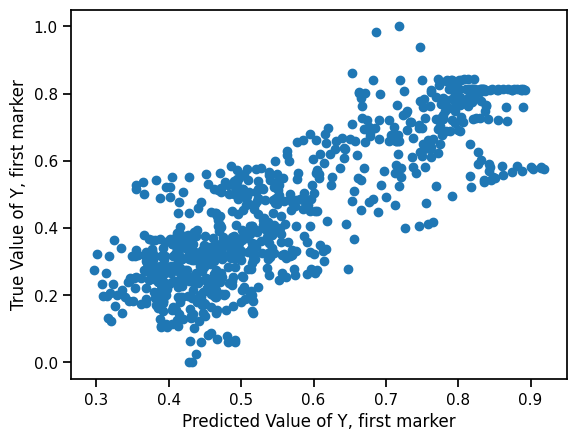

In [47]:
from itertools import product

num_folds = 5
dim_reduce = True
num_dim = 10

alphas = np.logspace(-4, 3, 50)
pca_dimensions = np.arange(5,50,10)  # Define the PCA dimensions to search over

test_score = []
train_score = []
best_a_list = []
best_dim_list = []

# Define the grid of parameters to search over
param_grid = list(product(alphas, pca_dimensions))

for i in range(num_folds):
    train_score_a = []
    val_score_a = []

    best_score = -np.inf  # Initialize best score to negative infinity
    best_model = None
    best_a = 0
    best_dim = 5

    for a, dim in param_grid:
        if dim_reduce == True:
            PCA_model = PCA(dim).fit(X_train['fold'+str(i)])
            X_train_ = PCA_model.transform(X_train['fold'+str(i)])
            X_val_ = PCA_model.transform(X_val['fold'+str(i)])
            X_test_ = PCA_model.transform(X_test['fold'+str(i)])


        model = Ridge(alpha=a, fit_intercept=True)
        model.fit(X_train_, y_train['fold'+str(i)])
        score = model.score(X_val_, y_val['fold'+str(i)])
        train_score_a.append(model.score(X_train_, y_train['fold'+str(i)]))
        val_score_a.append(score)

        # Check if current model has better validation score than previous best
        if score > best_score:
            best_score = score
            best_model = model
            best_a = a  # Update best alpha
            best_dim = dim  # Update best PCA dimension

    best_a_list.append(best_a)
    best_dim_list.append(best_dim)
    PCA_model = PCA(best_dim).fit(X_train['fold'+str(i)])
    X_train_ = PCA_model.transform(X_train['fold'+str(i)])
    X_val_ = PCA_model.transform(X_val['fold'+str(i)])
    X_test_ = PCA_model.transform(X_test['fold'+str(i)])
    model = Ridge(alpha=best_a, fit_intercept=True)
    model.fit(X_train_, y_train['fold'+str(i)])
    test_score.append(model.score(X_test_, y_test['fold'+str(i)]))
    train_score.append(model.score(X_train_, y_train['fold'+str(i)]))
    if i == 0:
        plt.scatter(model.predict(X_test_)[:,1], y_test['fold'+str(i)][:,1])
        plt.ylabel('True Value of Y, first marker')
        plt.xlabel('Predicted Value of Y, first marker')


In [48]:
best_a_list

[10.0,
 0.13894954943731375,
 0.0005179474679231213,
 0.03727593720314938,
 3.727593720314938]

In [49]:
best_dim_list

[35, 35, 45, 45, 35]

In [50]:
test_score

[0.4031886556439714,
 0.5024873809244416,
 0.5537060819134122,
 0.4273749986324158,
 0.5181086321567246]

In [51]:
train_score

[0.6388163820891687,
 0.6483535555201281,
 0.647860080422418,
 0.6894478769244557,
 0.6244665952113367]

## LSTM

In [52]:
fold_num = 'fold4'
fold = 4

In [53]:
X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]

In [54]:
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]

In [55]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32

# Helper function to convert between numpy arrays and tensors
# to_t = lambda array: torch.tensor(array, device='cpu', dtype=dtype)  #device
# to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
# from_t = lambda tensor: tensor.to("cpu").detach().numpy()

path_to_data = './Data'
#path_to_json_exp = './'
path_to_models = './Models'


In [56]:
seq_length_LSTM = 10
#X, Y = create_dataset(X, Y, lookback=seq_length)
#X_val, Y_val = create_dataset(X_val, Y_val, lookback=seq_length_LSTM)
reshape_input = True
batch_size_train= int(max(X_train.shape[0]/15,25))
batch_size_val= int(max(X_val.shape[0]/15,25)) # it was 1024, but here we have only 75 samples 
num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

In [57]:
num_epochs = 1000

seq_length = 75 #samples per reach trial.

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

In [58]:
seed = 42
torch.manual_seed(seed)

learning_rate = 0.0001 # it worked at 0.001
Loss_function = mean_squared_loss

Loss_function = globals().get(huber_loss)
Reg = globals().get(Regularizer_LSTM)

In [59]:
# Fit the LSTM model
model = CausalTemporalLSTM(num_features= num_features, 
                hidden_units= 64, #was 128
                #initial_offset = -2,
                num_layers = 2, # it was 1
                out_dims = num_dim_output).to(device)
train_losses, val_losses = \
    train_model(model, 
                xx_train, 
                yy_train,
                xx_val, 
                yy_val,
                huber_loss, 
                regularizer=Reg, #1e-5
                lr= learning_rate, 
                num_epochs=num_epochs, 
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                lr_gamma=0.9) 

Epoch 000 Train 0.0251 Val 0.0392
Epoch 001 Train 0.0243 Val 0.0382
Epoch 002 Train 0.0233 Val 0.0368
Epoch 003 Train 0.0220 Val 0.0347
Epoch 004 Train 0.0203 Val 0.0319
Epoch 005 Train 0.0182 Val 0.0285
Epoch 006 Train 0.0160 Val 0.0253
Epoch 007 Train 0.0141 Val 0.0230
Epoch 008 Train 0.0129 Val 0.0215
Epoch 009 Train 0.0122 Val 0.0207
Epoch 010 Train 0.0116 Val 0.0201
Epoch 011 Train 0.0112 Val 0.0195
Epoch 012 Train 0.0108 Val 0.0190
Epoch 013 Train 0.0105 Val 0.0184
Epoch 014 Train 0.0101 Val 0.0179
Epoch 015 Train 0.0098 Val 0.0174
Epoch 016 Train 0.0095 Val 0.0170
Epoch 017 Train 0.0092 Val 0.0165
Epoch 018 Train 0.0090 Val 0.0161
Epoch 019 Train 0.0088 Val 0.0158
Epoch 020 Train 0.0086 Val 0.0154
Epoch 021 Train 0.0084 Val 0.0151
Epoch 022 Train 0.0082 Val 0.0149
Epoch 023 Train 0.0081 Val 0.0146
Epoch 024 Train 0.0079 Val 0.0143
Epoch 025 Train 0.0078 Val 0.0141
Epoch 026 Train 0.0076 Val 0.0139
Epoch 027 Train 0.0075 Val 0.0137
Epoch 028 Train 0.0074 Val 0.0134
Epoch 029 Trai

NEXT:
- PREPARE TEMPLATE FROM LATEX WITH THE INTRO, DATA EXPLANATION, BASELINE MODELS...


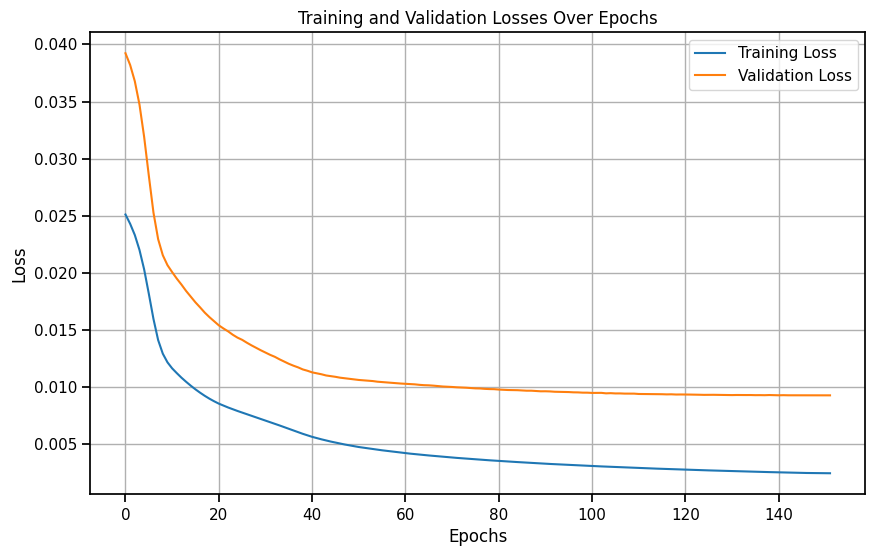

In [60]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [61]:
path_to_models = './Models'
experiment_name = 'First_test_LSTM'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4)

In [62]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'rmse')

Train Score: 0.06 RMSE
Train Score: 0.13 RMSE
Train Score: 0.13 RMSE


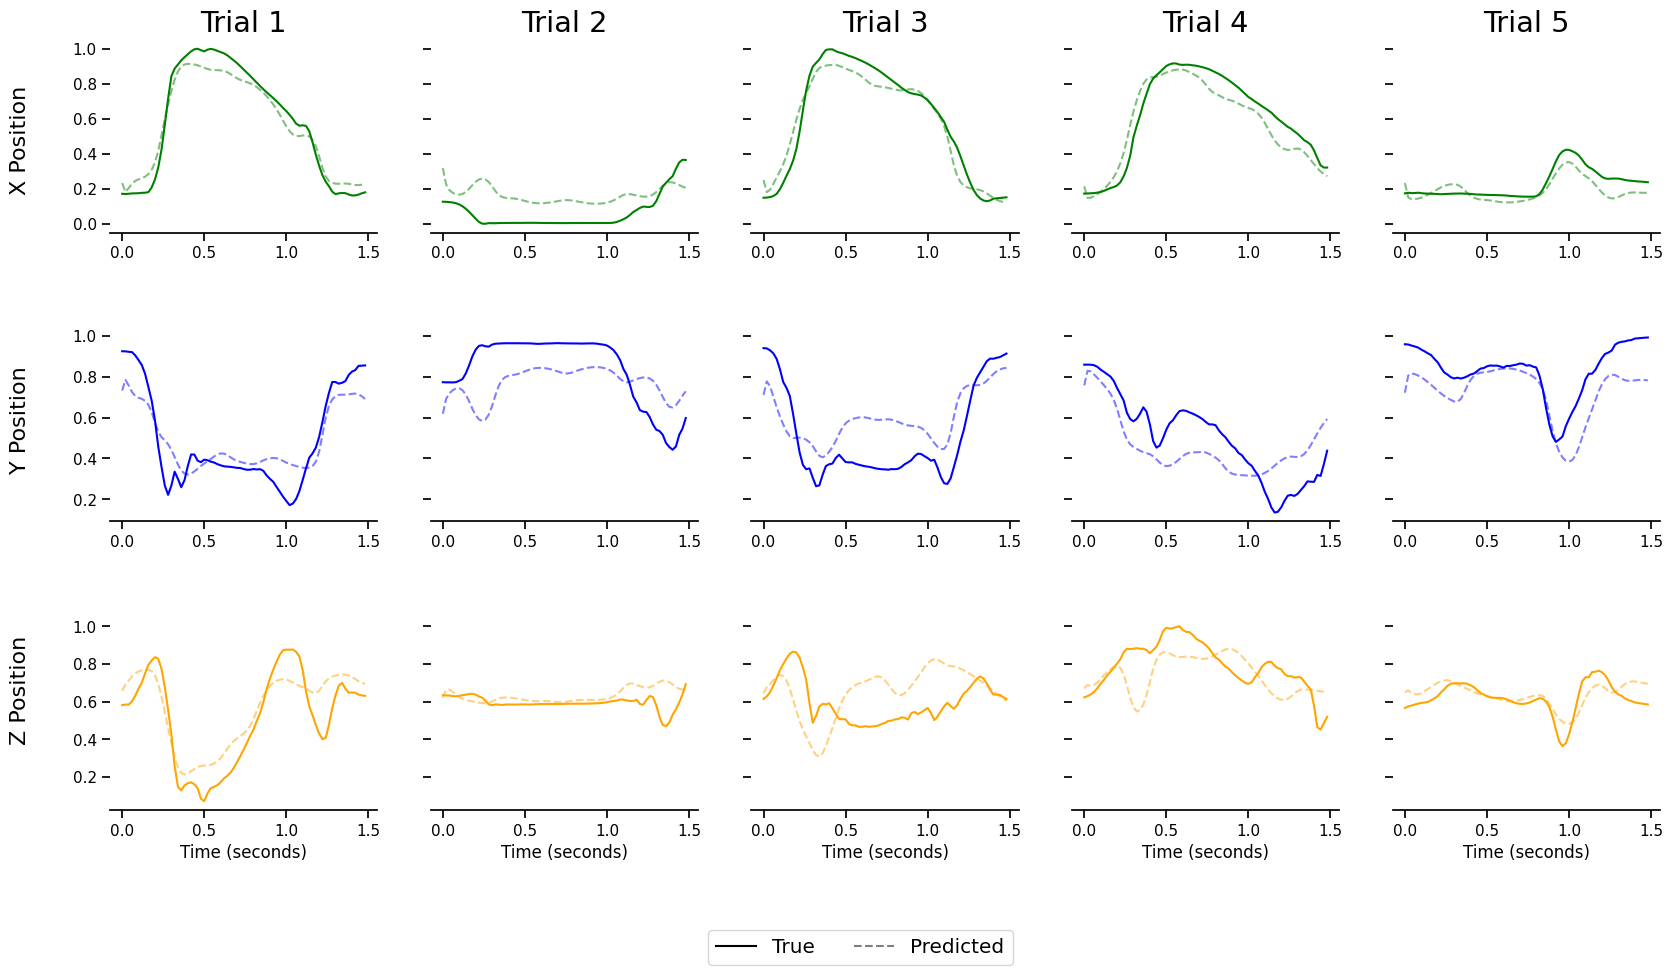

In [63]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)